# Analysis of Yelp Business Intelligence Data

We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset) although we have taken steps to pull this data into a publis s3 bucket: s3://yelp-9760-dataset/*.json

# Installation and Initial Setup

Begin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install pandas and matplotlib

In [3]:
sc.install_pypi_package("matplotlib==3.2.1")
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("seaborn==0.10.0")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Importing

Now, import the installed packages from the previous block below.

In [4]:
import pandas
import matplotlib.pyplot as plt
import seaborn as sns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Loading Data

We are finally ready to load data. Using spark load the data from S3 into a dataframe object that we can manipulate further down in our analysis.

In [5]:
df_business = spark.read.json('s3://yelp-9760-dataset/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Overview of Data

Display the number of rows and columns in our dataset.

In [7]:
print(f'Columns: {len(df_business.columns)} | Rows: {df_business.count()}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Columns: 14 | Rows: 209393

Display the DataFrame schema below.

In [8]:
df_business.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str


Display the first 5 rows with the following columns:

* business_id
* name
* city
* state
* categories

In [9]:
df_business.select('business_id','name','city','state','categories').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+
|         business_id|                name|           city|state|          categories|
+--------------------+--------------------+---------------+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+--------------------+
only showing top 5 rows

# Analyzing Categories

Let's now answer this question: how many unique categories are represented in this dataset?

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

How many businesses are categorized as Active Life, for instance
What are the top 20 most popular categories available?

## Association Table

We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:

| business_id | categories |
|-------------|------------|
| abcd123    | a,b,c      |

We would like to derive something like:

| business_id | category   |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |

What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

In [10]:
df_categories = df_business.select('business_id','categories')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
from pyspark.sql.functions import split, explode
df_category = df_categories.select('business_id', explode(split('categories', ', ')).alias('category'))
df_category.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|        category|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

## Total Unique Categories

Finally, we are ready to answer the question: what is the total number of unique categories available?

In [12]:
print(df_category.select('category').dropDuplicates().count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

## Top Categories By Business
Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category
So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

In [13]:
df_category.groupby('category').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|           category|count|
+-------------------+-----+
|     Dermatologists|  341|
|   Historical Tours|   54|
|Mobile Home Dealers|   16|
|     Paddleboarding|   36|
|   Hot Air Balloons|   21|
|       Aerial Tours|   28|
|      Skating Rinks|  104|
|  Signature Cuisine|    1|
|             Fondue|   54|
|      Data Recovery|  195|
|  Pet Waste Removal|   34|
|      Videographers|  169|
|    Pet Photography|   49|
|        Boat Repair|  100|
|            Beaches|   74|
|       Contract Law|   13|
|        Hobby Shops|  828|
|           Day Spas| 2880|
|              Reiki|  312|
|           Honduran|    8|
+-------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories
With this data available, let us now build a barchart of the top 20 categories.

**HINT**: don't forget about the matplotlib magic!

    %matplot plt

In [14]:
top20 = df_category.groupby('category').count().orderBy('count',ascending=False).limit(20)
top20.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|63944|
|            Shopping|34644|
|                Food|32991|
|       Home Services|22487|
|       Beauty & Spas|20520|
|    Health & Medical|19227|
|      Local Services|15783|
|          Automotive|14720|
|           Nightlife|14211|
|                Bars|12400|
|Event Planning & ...|11263|
|         Active Life|10225|
|        Coffee & Tea| 8415|
|             Fashion| 8374|
|           Fast Food| 8106|
|          Sandwiches| 8064|
|American (Traditi...| 7596|
|       Home & Garden| 7331|
|         Hair Salons| 7303|
|               Pizza| 7302|
+--------------------+-----+

In [15]:
top20_pd = top20.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

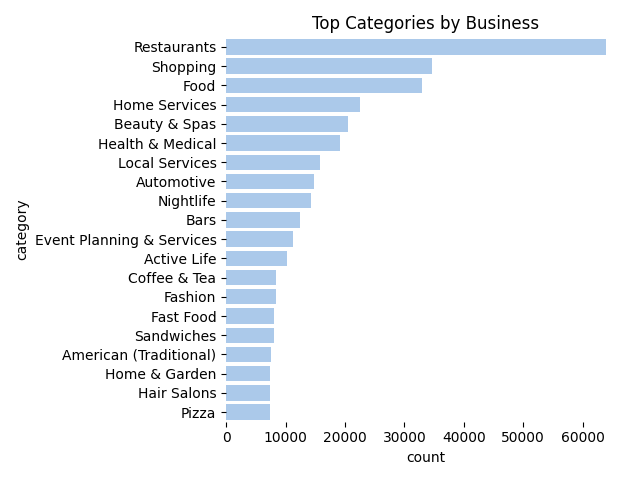

In [16]:
sns.set_color_codes("pastel")
sns.barplot(x="count", y="category", 
            data=top20_pd,color="b").set_title('Top Categories by Business').figure.tight_layout()
sns.despine(left=True, bottom=True)
%matplot plt

# Do Yelp Reviews Skew Negative?
Oftentimes, it is said that the only people who write a written review are those who are extremely dissatisfied or extremely satisfied with the service received.

How true is this really? Let's try and answer this question.

## Loading User Data
Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [17]:
df_review = spark.read.json('s3://yelp-9760-dataset/yelp_academic_dataset_review.json')
df_review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

Let's begin by listing the business_id and stars columns together for the user reviews data.

In [18]:
review = df_review.select('business_id', 'stars')
review.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the stars column to get a resultant dataframe that displays average stars per business as accumulated by users who **took the time to submit a written review.**

In [19]:
user_review = df_review.select('business_id','text', 'stars')
user_review.createOrReplaceTempView('review_table')
query_review = ''' SELECT business_id, AVG(stars)
            FROM review_table
            WHERE text IS NOT NULL
            GROUP BY business_id'''
review_table_df = spark.sql(query_review)
review_table_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vQGZjrDiDBuznOkUe...| 4.454545454545454|
|vyu1WGlnHGv2Z2MVE...|               5.0|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+
only showing top 5 rows

In [20]:
business = df_business.select('business_id','stars','name','city','state')
bus_rev = business.join(review_table_df, on=['business_id'], how='inner')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
bus_rev_order = bus_rev.select('avg(stars)','stars','name','city','state').orderBy('avg(stars)',ascending = False)
bus_rev_order.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+--------------------+---------+-----+
|avg(stars)|stars|                name|     city|state|
+----------+-----+--------------------+---------+-----+
|       5.0|  5.0|         Print Smart| Chandler|   AZ|
|       5.0|  5.0|Martial Arts Cent...|Las Vegas|   NV|
|       5.0|  5.0|     Herbology Tours|Las Vegas|   NV|
|       5.0|  5.0|             Rococoa|  Toronto|   ON|
|       5.0|  5.0|Just Teazzin Hair...|     Mesa|   AZ|
+----------+-----+--------------------+---------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the skew (for lack of a better word) between the avg stars accumulated from written reviews and the actual star rating of a business (ie: the average of stars given by reviewers who wrote an actual review and reviewers who just provided a star rating).

The formula you can use is something like:

    (row['avg(stars)'] - row['stars']) / row['stars']
If the skew is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If skew is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [22]:
bus_rev_skew = bus_rev_order.withColumn('skew', 
                                        (bus_rev_order['avg(stars)'] - bus_rev_order['stars'])/bus_rev_order['stars'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
skew_pd = bus_rev_skew.select('skew').toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

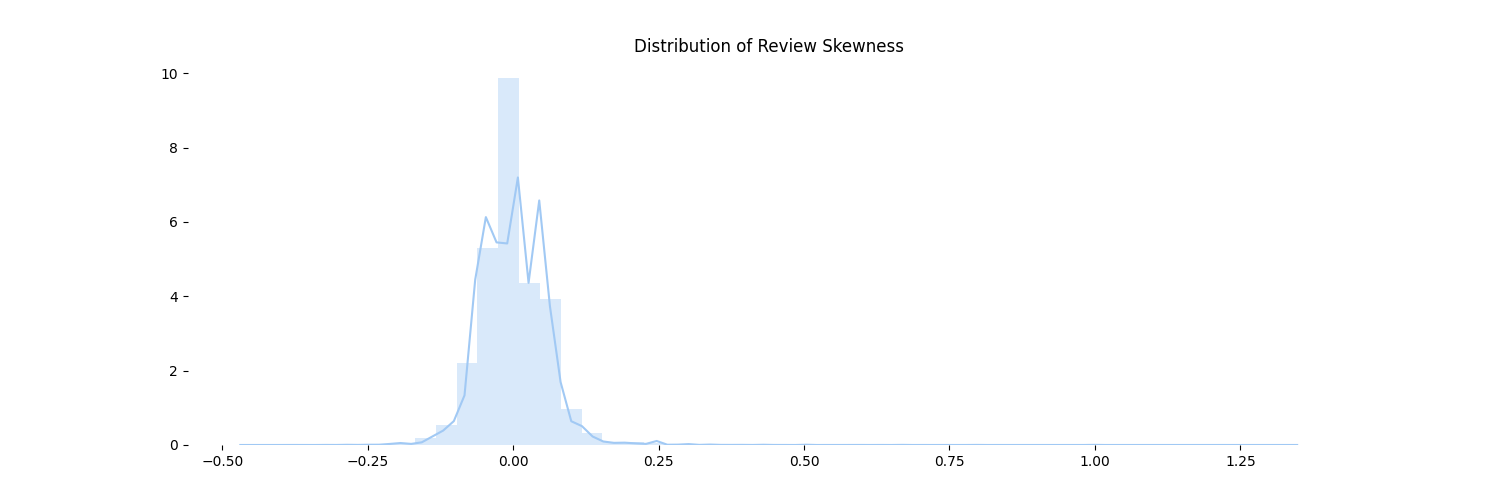

In [24]:
sns.set_color_codes("pastel")
f, ax = plt.subplots(figsize = (15,5))
sns.distplot(skew_pd, ax = ax, color = 'b')
ax.set_title('Distribution of Review Skewness')
sns.despine(left=True, bottom=True)

%matplot plt

From the plot we could see Yelp written Reviews do not skew negative. They are actually slightly skew positive. It shows customers tend to give more efforts in writing reviews when they have positive experience. To be more accurate, hypothese testing is needed to see whether the difference is significant.  

# Should the Elite be Trusted? 

In this part, we will analyze how accurate or close are the ratings of an "elite" user vs the actual business rating.

First, let's load the user data and check the schema.

In [25]:
df_user = spark.read.json('s3://yelp-9760-dataset/yelp_academic_dataset_user.json')
df_user.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- average_stars: double (nullable = true)
 |-- compliment_cool: long (nullable = true)
 |-- compliment_cute: long (nullable = true)
 |-- compliment_funny: long (nullable = true)
 |-- compliment_hot: long (nullable = true)
 |-- compliment_list: long (nullable = true)
 |-- compliment_more: long (nullable = true)
 |-- compliment_note: long (nullable = true)
 |-- compliment_photos: long (nullable = true)
 |-- compliment_plain: long (nullable = true)
 |-- compliment_profile: long (nullable = true)
 |-- compliment_writer: long (nullable = true)
 |-- cool: long (nullable = true)
 |-- elite: string (nullable = true)
 |-- fans: long (nullable = true)
 |-- friends: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- name: string (nullable = true)
 |-- review_count: long (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)
 |-- yelping_since: string (nullable = true)

In [52]:
df_elite_all = df_user.select('user_id','elite')
df_elite_all.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|             user_id|               elite|
+--------------------+--------------------+
|ntlvfPzc8eglqvk92...|                    |
|FOBRPlBHa3WPHFB5q...|2008,2009,2010,20...|
|zZUnPeh2hEp0WydbA...|                2010|
|QaELAmRcDc5TfJEyl...|                2009|
|xvu8G900tezTzbbfq...|2009,2010,2011,20...|
|z5_82komKV3mI4ASG...|                2007|
|ttumcu6hWshk_EJVW...|                    |
|f4_MRNHvN-yRn7EA8...|2011,2012,2013,20...|
|UYACF30806j2mfbB5...|                    |
|QG13XBbgHWydzThRB...|           2008,2009|
|f6YuZP6iennHFVlnF...|                    |
|I_6wY8_RsewziNnKh...|2010,2011,2012,20...|
|q-v8elVPvKz0KvK69...|2011,2012,2013,20...|
|HwPGLzF_uXB3MF8bc...|                    |
|y4UuVowA9i3zj2hHy...|                    |
|1WBxJ2r3A2QYfRSEz...|2010,2011,2012,20...|
|-TT5e-YQU9xLb1JAG...| 2010,2011,2012,2013|
|6bbHSJ0PrgSxh7e5n...|                    |
|4VmuXuSRhv5UxYUy3...|           2012,2013|
|pVU2DdtBFppBAX5G5...|          

In [53]:
df_elite_all.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1968703

From above table, we could see that elite column lists all the years that the user had 'elite' title. Let's first filter all the user that had been titled 'elite' at least once.

In [54]:
import pyspark.sql.functions as f
df_elite = df_elite_all.filter(f.length('elite') != 0)
df_elite.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|             user_id|               elite|
+--------------------+--------------------+
|FOBRPlBHa3WPHFB5q...|2008,2009,2010,20...|
|zZUnPeh2hEp0WydbA...|                2010|
|QaELAmRcDc5TfJEyl...|                2009|
|xvu8G900tezTzbbfq...|2009,2010,2011,20...|
|z5_82komKV3mI4ASG...|                2007|
|f4_MRNHvN-yRn7EA8...|2011,2012,2013,20...|
|QG13XBbgHWydzThRB...|           2008,2009|
|I_6wY8_RsewziNnKh...|2010,2011,2012,20...|
|q-v8elVPvKz0KvK69...|2011,2012,2013,20...|
|1WBxJ2r3A2QYfRSEz...|2010,2011,2012,20...|
|-TT5e-YQU9xLb1JAG...| 2010,2011,2012,2013|
|4VmuXuSRhv5UxYUy3...|           2012,2013|
|PamWn4FZwRiCYMdTw...|                2012|
|3o09Ya5VcRVMN3b2s...|           2011,2012|
|Lwyjwmodkmw4b9axr...| 2013,2014,2015,2016|
|EFM7rmwvSEUbEGMWS...|                2011|
|dIIKEfOgo0KqUfGQv...|2007,2008,2009,20...|
|q_QQ5kBBwlCcbL1s4...|2006,2007,2008,20...|
|-ySXNLiIspI4UC8Qn...|      2009,2010,2011|
|JnPIjvC0cmooNDfsa...|2009,2010,

In [55]:
df_elite.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

75961

And then, let's spread it out to aid further analysis.

In [61]:
df_elite_spread = df_elite.select('user_id', explode(split('elite', ',')).alias('year'))
df_elite_spread.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----+
|             user_id|year|
+--------------------+----+
|FOBRPlBHa3WPHFB5q...|2008|
|FOBRPlBHa3WPHFB5q...|2009|
|FOBRPlBHa3WPHFB5q...|2010|
|FOBRPlBHa3WPHFB5q...|2011|
|FOBRPlBHa3WPHFB5q...|2012|
|FOBRPlBHa3WPHFB5q...|2013|
|zZUnPeh2hEp0WydbA...|2010|
|QaELAmRcDc5TfJEyl...|2009|
|xvu8G900tezTzbbfq...|2009|
|xvu8G900tezTzbbfq...|2010|
|xvu8G900tezTzbbfq...|2011|
|xvu8G900tezTzbbfq...|2012|
|xvu8G900tezTzbbfq...|2014|
|xvu8G900tezTzbbfq...|2015|
|xvu8G900tezTzbbfq...|2016|
|xvu8G900tezTzbbfq...|2017|
|xvu8G900tezTzbbfq...|2018|
|z5_82komKV3mI4ASG...|2007|
|f4_MRNHvN-yRn7EA8...|2011|
|f4_MRNHvN-yRn7EA8...|2012|
+--------------------+----+
only showing top 20 rows

We will match the tables based on the user that left the review and was titled 'elite' in the same year. Thus, first, we will derive the year that the user left the review. And then join the review table with elite user table to select those reviews that left by elite users of that year.

In [58]:
review_p4 = df_review.select('business_id','stars','date','user_id')
review_p4.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+-------------------+--------------------+
|         business_id|stars|               date|             user_id|
+--------------------+-----+-------------------+--------------------+
|-MhfebM0QIsKt87iD...|  2.0|2015-04-15 05:21:16|OwjRMXRC0KyPrIlcj...|
|lbrU8StCq3yDfr-QM...|  1.0|2013-12-07 03:16:52|nIJD_7ZXHq-FX8byP...|
|HQl28KMwrEKHqhFrr...|  5.0|2015-12-05 03:18:11|V34qejxNsCbcgD8C0...|
|5JxlZaqCnk1MnbgRi...|  1.0|2011-05-27 05:30:52|ofKDkJKXSKZXu5xJN...|
|IS4cv902ykd8wj1TR...|  4.0|2017-01-14 21:56:57|UgMW8bLE0QMJDCkQ1...|
+--------------------+-----+-------------------+--------------------+
only showing top 5 rows

In [60]:
review_p4_year = review_p4.withColumn('year', review_p4.date.substr(1, 4))
review_p4_year = review_p4_year.drop('date')
review_p4_year.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+----+
|         business_id|stars|             user_id|year|
+--------------------+-----+--------------------+----+
|-MhfebM0QIsKt87iD...|  2.0|OwjRMXRC0KyPrIlcj...|2015|
|lbrU8StCq3yDfr-QM...|  1.0|nIJD_7ZXHq-FX8byP...|2013|
|HQl28KMwrEKHqhFrr...|  5.0|V34qejxNsCbcgD8C0...|2015|
|5JxlZaqCnk1MnbgRi...|  1.0|ofKDkJKXSKZXu5xJN...|2011|
|IS4cv902ykd8wj1TR...|  4.0|UgMW8bLE0QMJDCkQ1...|2017|
+--------------------+-----+--------------------+----+
only showing top 5 rows

In [62]:
elite_review = review_p4_year.join(df_elite_spread, on=['user_id','year'], how='inner')
elite_review.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----+--------------------+-----+
|             user_id|year|         business_id|stars|
+--------------------+----+--------------------+-----+
|-5uvOHRkvijt1vzSX...|2017|YWs-ZFQier0rFv1qa...|  4.0|
|-5uvOHRkvijt1vzSX...|2017|IbOrNwCdMTd-eicZ9...|  3.0|
|-5uvOHRkvijt1vzSX...|2017|zBrm-ejSU0QwDlpFy...|  4.0|
|-5uvOHRkvijt1vzSX...|2017|Lyzr1uckXL0U-iBoM...|  2.0|
|-5uvOHRkvijt1vzSX...|2017|4vHm-szf4WUn77MbJ...|  3.0|
|-6gYApoyPvez737nx...|2018|77h11eWv6HKJAgojL...|  4.0|
|-6gYApoyPvez737nx...|2018|nVAJZ6BJ9PPlxDXn9...|  4.0|
|-6gYApoyPvez737nx...|2018|XQETjKH84gxDrAiz2...|  4.0|
|-6gYApoyPvez737nx...|2018|qFAw6wHMMcr4ctF-Z...|  4.0|
|-6gYApoyPvez737nx...|2018|IWN2heYitkg-D4Udq...|  5.0|
|-6gYApoyPvez737nx...|2018|QXV3L_QFGj8r6nWX2...|  4.0|
|-6gYApoyPvez737nx...|2018|0d0i0FaJq1GIeW1rS...|  4.0|
|-6gYApoyPvez737nx...|2018|mU3vlAVzTxgmZUu6F...|  3.0|
|-DmqnhW4Omr3Yhmni...|2018|iFCz-xI7CV98fcaB4...|  5.0|
|-DmqnhW4Omr3Yhmni...|2018|JAmQCmczUclNUfZjk...|  5.0|
|-NbeVN5tn

And then. let's calculate the average stars rated by elite users for each business. 

In [64]:
elite_review.createOrReplaceTempView('elite_review_table')
query_elite_review = ''' SELECT business_id, AVG(stars) elite_stars
            FROM elite_review_table
            GROUP BY business_id'''
elite_review_df = spark.sql(query_elite_review)
elite_review_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------------+
|         business_id|      elite_stars|
+--------------------+-----------------+
|2UgRg5a6KmpbD_SZf...|4.326086956521739|
|issNocLJCc1YbTdnw...|            2.625|
|--9e1ONYQuAa-CB_R...|4.240641711229946|
|kbaXNZLUyVuWbeQxH...|3.880952380952381|
|SjgeuBlgKER9yegpo...|3.857142857142857|
+--------------------+-----------------+
only showing top 5 rows

To analysis the accuracy of elites' review, we will join the above table with bus_rev table, which we derived in previous analysis and then calculate the skewness of elite users.

In [66]:
bus_rev_elite = bus_rev.join(elite_review_df, on=['business_id'], how='inner')
bus_rev_elite.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+-------------+-----+------------------+------------------+
|         business_id|stars|                name|         city|state|        avg(stars)|       elite_stars|
+--------------------+-----+--------------------+-------------+-----+------------------+------------------+
|--9e1ONYQuAa-CB_R...|  4.0|Delmonico Steakhouse|    Las Vegas|   NV|  4.11784140969163| 4.240641711229946|
|-6c_bJblLXUwoWfmY...|  2.5|Neo-Paws Internat...|      Toronto|   ON|2.3333333333333335|               1.0|
|-I06hkMFrX0KBqu61...|  5.0|Andre Agassi Coll...|    Las Vegas|   NV|               5.0|               5.0|
|-Qb6U1MotJfpt6OU_...|  5.0|Woof Wise Dog Tra...|    Richfield|   OH|               5.0|               5.0|
|-RRnldwSqCZT6OpuW...|  5.0|           Grandiose|      Phoenix|   AZ|               5.0|               5.0|
|-TGwtTiieh_JLml5_...|  3.5|           Starbucks|Richmond Hill|   ON|               3.5|               3.6|
|-VAsjhmAbKF3Pb_-8...|  2.0|

In [67]:
elite_skew = bus_rev_elite.withColumn('elite_skew', 
                                        (bus_rev_elite['elite_stars'] - bus_rev_elite['stars'])/bus_rev_elite['stars'])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's plot the distribution of elite skewness.

In [68]:
elite_skew_pd = elite_skew.select('elite_skew').toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

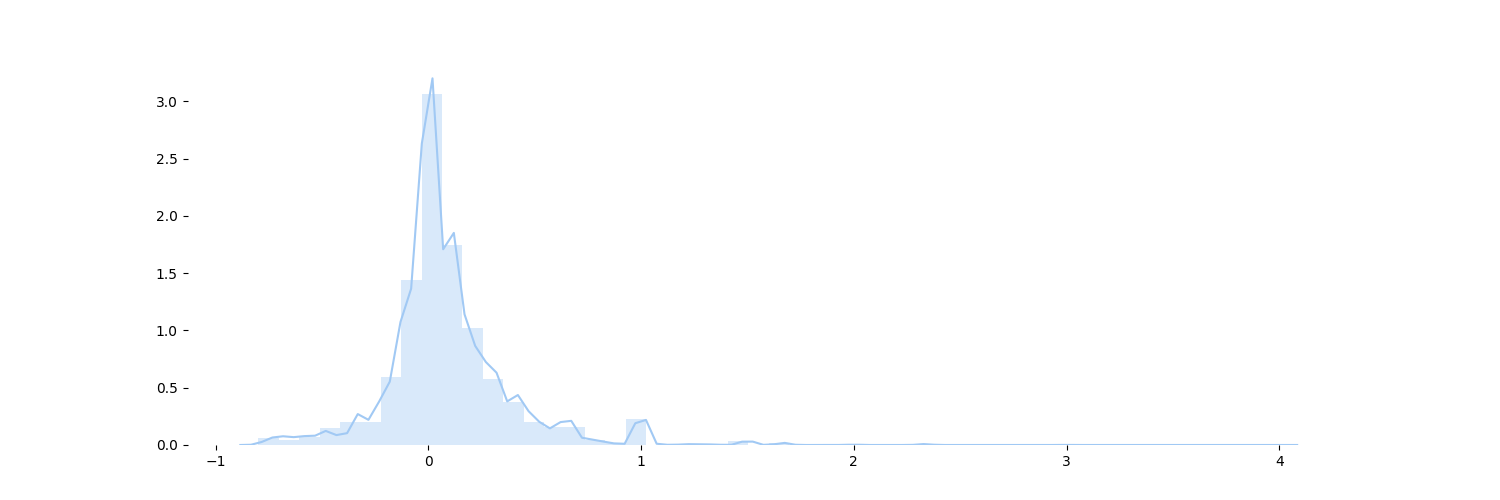

In [69]:
sns.set_color_codes("pastel")
f_e, ax_e = plt.subplots(figsize = (15,5))
sns.distplot(elite_skew_pd, ax = ax_e, color = 'b')
ax.set_title('Distribution of Elite Review Skewness')
sns.despine(left=True, bottom=True)

%matplot plt

From the plot we can see that elite users' ratings are skewed positive. Also, the right tail is pretty long and dramatic. I am interested in what kind of business tend to cause high skewness. Let's filter out some outliers. 

In [83]:
elite_skew.filter(elite_skew.elite_skew >= 3).show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+---------+-----+------------------+-----------+----------+
|         business_id|stars|                name|     city|state|        avg(stars)|elite_stars|elite_skew|
+--------------------+-----+--------------------+---------+-----+------------------+-----------+----------+
|MZY7F2Pmt7fJIeZ8V...|  1.0|            Buytopia|  Toronto|   ON|1.2307692307692308|        4.0|       3.0|
|wfSXu_b1Hha2VFIuh...|  1.0|           Taco Bell|   Peoria|   AZ|           1.21875|        4.0|       3.0|
|HqBRGZQ5OK601Oyg1...|  1.0|LivGenerations Ah...|  Phoenix|   AZ|               1.5|        4.0|       3.0|
|WyGVX3b7GqFj4MbFn...|  1.0|         TDS Telecom|  Madison|   WI|1.2150537634408602|        4.0|       3.0|
|zKeHgMw_yYcTuwxM4...|  1.0|Bojangles Restaurant|Charlotte|   NC|1.2352941176470589|        4.0|       3.0|
|ZGHMmErnJRKx5II4V...|  1.0|   Republic Services|  Phoenix|   AZ|1.1666666666666667|        4.0|       3.0|
|WVeFL6j0HixPqiPng...|  1.0|

Interestly, among those businesses that has very high elite skewness (>= 3), there are several service companies such as "The UPS Store", "TDS Telecom", etc. This leads us to another interesting question that could be conduct in future analysis -- will the business category affect elite users' rating accuracy. 

Let's see the numerical summary of the elite review.

In [82]:
elite_skew.select('stars', 'avg(stars)', 'elite_stars', 'elite_skew').describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------------------+------------------+------------------+
|summary|             stars|        avg(stars)|       elite_stars|        elite_skew|
+-------+------------------+------------------+------------------+------------------+
|  count|            129903|            129903|            129903|            129903|
|   mean| 3.557446710237639| 3.556136444407555|3.7701197840190104| 0.090370486316612|
| stddev|0.8802206156212453|0.8643455183227993|0.9528163514516326|0.2956290162381842|
|    min|               1.0|               1.0|               1.0|              -0.8|
|    max|               5.0|               5.0|               5.0|               4.0|
+-------+------------------+------------------+------------------+------------------+

In general, we could see that elite users' ratings indeed have higher mean and positive mean skewness. Potential reasons could be first, elite users are those who take time and make efforts in writing reviews. From previous analysis, we could see that such users already have tendency to rate higher. Second, there might be cooperations between business & elite users, as a way of promotion and advertisement. Thus, customers should bear that in mind when we use elite users' rating or review as the reference. 